# 1. Processing Test Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tfa-nightly
!pip install tensorflow-addons

     |████████████████████████████████| 747kB 13.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
from skimage.transform import rescale, resize
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VIN/fer2013.csv')

In [ ]:
df_test = df[df['Usage']=='PrivateTest']

In [ ]:
y_label = []
X_test = np.zeros((len(df_test), 48, 48,3), dtype=np.uint8)
X_res = np.zeros((48, 48,3), dtype=np.uint8)
i = 0
for emotion, pixels in zip(df_test['emotion'], df_test['pixels']):
  y_label.append(emotion)

  list_of_pixels = pixels.split(' ')
  img_pixel = np.asarray(list_of_pixels, dtype=np.uint8).reshape(48,48,1)
  for k in range(48):
    for l in range(48):
      X_res[k,l,:] = img_pixel[k,l,0]
  X_test[i] = X_res
  i += 1
y_label = np.array(y_label)

In [ ]:
X_test.shape

(3589, 48, 48, 3)

In [ ]:
np.save("/content/drive/MyDrive/Ensemble/y_label.npy", y_label)

# 2. Resnet 50 model

In [ ]:
resnet_x_test =np.stack([resize(X_test[i], (197,197,3)) for i in range(y_label.shape[0])], axis = 0)

In [ ]:
resnet_x_test.shape

(3589, 197, 197, 3)

In [ ]:
Resnet50_model = tf.keras.models.load_model("/content/drive/MyDrive/Ensemble/Resnet50/Resnet50_8_12.h5")

In [ ]:
Resnet50_y_pred =Resnet50_model.predict(resnet_x_test)

In [ ]:
Resnet50_y_pred = np.array([np.argmax(Resnet50_y_pred[i]) for i in range(len(Resnet50_y_pred))])

In [ ]:
Resnet50_y_pred.shape

(3589,)

In [ ]:
y_label

array([0, 5, 6, ..., 0, 3, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_label, Resnet50_y_pred)

0.7085539147394817

In [ ]:
np.save("/content/drive/MyDrive/Ensemble/Resnet50_y_pred.npy", Resnet50_y_pred)

# 3. VGG16 model

In [ ]:
Vgg_x_test =np.stack([resize(X_test[i], (224,224,3)) for i in range(y_label.shape[0])], axis = 0)

In [ ]:
Vgg_x_test.shape

(3589, 224, 224, 3)

In [ ]:
VGG16_model = tf.keras.models.load_model("/content/drive/MyDrive/Ensemble/VGG16/VGGFace16.h5")

In [ ]:
VGG16_y_pred =VGG16_model.predict(Vgg_x_test)

In [ ]:
VGG16_y_pred = np.array([np.argmax(VGG16_y_pred[i]) for i in range(len(VGG16_y_pred))])

In [ ]:
VGG16_y_pred.shape

(3589,)

In [ ]:
y_label

array([0, 5, 6, ..., 0, 3, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_label, VGG16_y_pred)

0.694901086653664

In [ ]:
np.save("/content/drive/MyDrive/Ensemble/VGG16_pred.npy", VGG16_y_pred)

# 4. Baseline model

In [ ]:
baseline_x_test = np.zeros((len(df_test), 48, 48,1), dtype=np.uint8)
i = 0
for emotion, pixels in zip(df_test['emotion'], df_test['pixels']):
  list_of_pixels = pixels.split(' ')
  img_pixel = np.asarray(list_of_pixels, dtype=np.uint8).reshape(48,48,1)
  baseline_x_test[i] = img_pixel
  i += 1

baseline_x_test = baseline_x_test/255.

In [ ]:
baseline_x_test.shape

(3589, 48, 48, 1)

In [ ]:
baseline_model = tf.keras.models.load_model("/content/drive/MyDrive/Ensemble/baseline/Baseline.h5")

In [ ]:
Basemodel_y_pred =baseline_model.predict(baseline_x_test)

In [ ]:
Basemodel_y_pred = np.array([np.argmax(Basemodel_y_pred[i]) for i in range(len(Basemodel_y_pred))])

In [ ]:
Basemodel_y_pred.shape

(3589,)

In [ ]:
y_label

array([0, 5, 6, ..., 0, 3, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_label, Basemodel_y_pred)

0.6923934243521872

In [ ]:
np.save("/content/drive/MyDrive/Ensemble/Basemodel_y_pred.npy", Basemodel_y_pred)

In [ ]:
!rm -rf fer2013
!mkdir fer2013
!mkdir fer2013/train
!mkdir fer2013/test
! unzip -q '/content/drive/MyDrive/fer2013/train.zip' -d fer2013/train
! unzip -q '/content/drive/MyDrive/fer2013/test-public.zip' -d fer2013/valid
! unzip -q '/content/drive/MyDrive/fer2013/test-private.zip' -d fer2013/test

In [ ]:
# Dataset Directory
train_dir='fer2013/train'
validation_dir='fer2013/valid'
test_dir = 'fer2013/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range = [0.8,1.2],
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 64

In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 validation_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

test_generator = test_datagen.flow_from_directory(
 test_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
print('\n# Evaluate on test data')
results_test = VGG16_model.evaluate_generator(test_generator, 3589 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
Instructions for updating:
Please use Model.evaluate, which supports generators.
test loss, test acc: [0.858756422996521, 0.7067522406578064]


# TỔNG HỢP

In [4]:
import numpy as np
y_true_label = np.load("/content/drive/MyDrive/VIN/Ensemble/y_label.npy")
baseline = np.load("/content/drive/MyDrive/VIN/Ensemble/Basemodel_y_pred.npy")
vgg16 = np.load("/content/drive/MyDrive/VIN/Ensemble/VGG16_pred.npy")
resnet = np.load("/content/drive/MyDrive/VIN/Ensemble/Resnet50_y_pred.npy")
facenet = np.load('/content/drive/MyDrive/VIN/Ensemble/Facenet/Facenet_y_pred.npy')
effnet = np.load('/content/drive/MyDrive/VIN/Ensemble/EffNet/Effnet_y_pred.npy')

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
accuracy_score(y_true_label,baseline)

0.6923934243521872

In [7]:
accuracy_score(y_true_label,vgg16)

0.694901086653664

In [8]:
accuracy_score(y_true_label,resnet)

0.7085539147394817

In [9]:
accuracy_score(y_true_label,facenet)

0.7018668152688772

In [10]:
accuracy_score(y_true_label,effnet)

0.7110615770409585

In [11]:
ensemble = []
for i in range(len(y_true_label)):
  ret = np.array([baseline[i], vgg16[i], resnet[i], facenet[i], effnet[i]])
  (values,counts) = np.unique(ret,return_counts=True)
  ind=np.argmax(counts)
  ensemble.append(values[ind])

ensemble = np.array(ensemble)

In [12]:
accuracy_score(y_true_label,ensemble)

0.7475619949846753

In [13]:
from sklearn.metrics import confusion_matrix
a =confusion_matrix(y_true_label, ensemble)

In [20]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

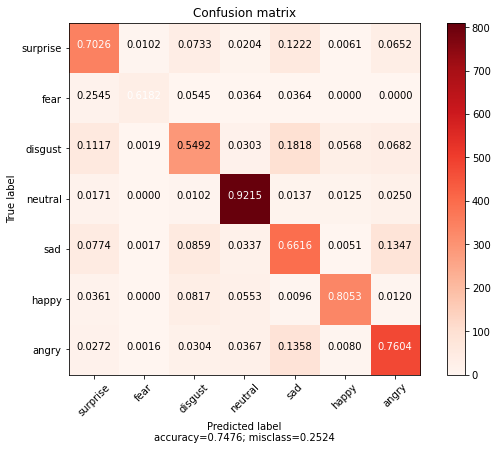

In [21]:
target_name = ["surprise", "fear", "disgust" ,"neutral" ,"sad" ,"happy","angry"]
plot_confusion_matrix(a, target_name)